In [1]:
!source activate py2

In [2]:
from functions_plot import *
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

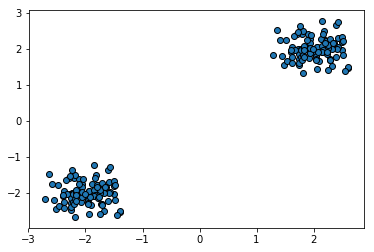

In [3]:
X = 0.3 * np.random.randn(100, 2)
X = np.r_[X + 2, X - 2]
plot(X)

In [4]:
class OCC:
    
    def __init__(self, X, step = 0.05, eps = 0):
        import matplotlib.pyplot as plt
        import numpy as np
        
        self.X = X
        self.n = X.shape[0]
        self.figsize = (10,5)
        
        # plot parameters
        self.step = step
        self.eps = eps
        self.norm_colors = mpl.colors.Normalize(vmin=0,vmax=100)
        self.set_grid()
        
        pass
    
    # Plot functions
    
    def plot(self):
        plt.scatter(self.X[:,0], self.X[:,1], edgecolors  = 'black')
        plt.xlim((min(self.X[:,0])-self.step,max(self.X[:,0])+self.step))
        plt.ylim((min(self.X[:,1])-self.step,max(self.X[:,1])+self.step))
        pass
    
    def set_grid(self):
        self.x_axis = np.arange(min(self.X[:,0])-self.step,max(self.X[:,0])+2*self.step,self.step)
        self.y_axis = np.arange(min(self.X[:,1])-self.step,max(self.X[:,1])+2*self.step,self.step)

        self.my_grid = []
        for i in self.x_axis:
            for j in self.y_axis:
                self.my_grid.append([i,j])
        self.my_grid = np.array(self.my_grid)

        pass

    def Normalize_Pred(self):    
        self.pred_100 = self.pred -np.min(self.pred)
        self.pred_100 = (self.pred_100 / np.max(self.pred_100)) * 100
        pass

    def set_delim(self):
        ix_delim = np.where((self.pred  < self.eps) & (self.pred  > -self.eps))[0]
        self.x_delim = []
        self.y_delim = []
        for i in range(len(ix_delim)):
            a, b = np.divmod(ix_delim[i],len(self.y_axis))
            self.x_delim.append(self.x_axis[a])
            self.y_delim.append(self.y_axis[b])
        pass

    def plot_pred(self, pred):
        
        X_axis, Y_axis = np.meshgrid(self.x_axis, self.y_axis)
        C = np.transpose(pred.reshape((len(self.x_axis), len(self.y_axis))))
        plt.pcolor(X_axis, Y_axis, C, norm = self.norm_colors, cmap = 'YlOrRd')
        plt.scatter(self.x_delim, self.y_delim, c = 'black', s = 10)
        self.plot()
        pass

    def plot_pred_plan(self):
        self.pred = self.predict(self.my_grid)
        self.pred_bin = np.sign(self.pred)
        self.set_delim()
        self.Normalize_Pred()
        
        plt.figure(figsize=self.figsize)
        plt.subplot(1,2,1)
        self.plot_pred(self.pred_100)
        plt.subplot(1,2,2)
        self.plot_pred((self.pred_bin+1)*100)
        pass
    
    
    # Skeletons for fit and predict
    def fit(self):
        pass
    
    def predict(self):
        pass
    
    # Others methods
    def RBF_Kernel(self, X, sigma2, Y = None):
        " Compute the RBF kernel matrix of X"
        from sklearn.metrics.pairwise import euclidean_distances

        if type(Y)==type(None):
            Y = X

        K = euclidean_distances(X,Y, squared=True)
        K *= -1./sigma2
        K = np.exp(K)
        return K

In [5]:
class OSVM(OCC):
    " Support Vector Method for Novelty Detection \
      Bernhard Schokopf, Robert Williamsonx, Alex Smolax, John Shawe-Taylory, John Platt \
      Quadratic Programming "
    
    def fit(self, nu, sigma2):
        from cvxopt import solvers, lapack, matrix, spmatrix
        solvers.options['show_progress'] = 0
        
        n = self.n
        self.sigma2 = sigma2
        K = self.RBF_Kernel(self.X, sigma2)

        P = matrix(K, tc = 'd')
        q = matrix([0]*n, tc = 'd')
        G = matrix(np.concatenate([np.eye(n),-np.eye(n)], axis = 0), tc = 'd')
        h_value = [1./(n * nu)]*n
        h_value.extend([0]*n)
        h = matrix(h_value, tc = 'd')
        A = matrix(np.reshape([1]*n, (1,n)), tc = 'd')
        b = matrix(1, tc = 'd')

        sol = solvers.qp(P,q,G,h,A,b)
        self.alpha = np.array(sol['x'])
        ix_in = np.where((self.alpha > 1e-5) & (self.alpha < 1./(n*nu)))[0][0]
        self.rho = np.inner(np.reshape(self.alpha, (1,n)), K[:,ix_in])
        pass

    def predict(self, newData):
        K = self.RBF_Kernel(self.X, self.sigma2, newData)
        return np.transpose(np.dot(np.reshape(self.alpha, (1,self.n)), K) - self.rho)

In [6]:
class OSVM2(OCC):
    " Simple Incremental One-Class Support Vector Classification \
      Kai Labusch, Fabian Timm, and Thomas Martinetz "
    
    def RBF_Kernel(self, X, sigma2, Y = None):
        " Compute the RBF kernel matrix of X"
        from sklearn.metrics.pairwise import euclidean_distances

        if type(Y)==type(None):
            Y = X

        K = euclidean_distances(X,Y, squared=True)
        K *= -1./sigma2
        K = np.exp(K)
        return K
    
    def fit(self, nu, sigma2):
        
        n = self.n
        self.sigma2 = sigma2
        
        K = self.RBF_Kernel(X, sigma2)
        alpha = np.zeros(n)
        count = 0
        Z = X.copy()
        i_min = np.random.choice(range(n), 1)
        i_max = np.random.choice(range(n), 1)
        while (i_max == i_min):
            i_max = np.random.choice(range(n), 1)

        while count < 1000:
            count = count + 1
            K = osvm.RBF_Kernel(Z, 1)
            h = np.dot(K + (n*nu)/2 * np.eye(n), alpha)
            i_min2 = np.argmin(h)
            ix_in = np.where(alpha > 1e-7)[0]
            if len(ix_in) > 0:
                i_max2 = ix_in[np.argmax(h[ix_in])]
            else:
                i_max2 = np.argmax(h)
            Z[i_min,:] = Z[i_min2,:]
            Z[i_max,:] = Z[i_max2,:]
            i_min = i_min2
            i_max = i_max2
            i_min_alpha = np.argmin(alpha)
            i_max_alpha = np.argmax(alpha)
            alpha[i_min_alpha] = alpha[i_min_alpha]+2
            alpha[i_max_alpha] = alpha[i_max_alpha]-1

        h = np.dot(K + (n*nu)/2 * np.eye(n), alpha)
        self.alpha = alpha / np.sqrt(np.dot(alpha, h))
        h = np.dot(K + (n*nu)/2 * np.eye(n), self.alpha)
        self.rho = min(h)
        pass

    def predict(self, newData):
        K = self.RBF_Kernel(self.X, self.sigma2, newData)
        return np.transpose(np.dot(np.reshape(self.alpha, (1,self.n)), K) - self.rho)

In [18]:
class OkNN(OCC):
    
    " Multi-Class and Single-Class Classification Approaches to Vehicle Model Recognition from Images \
      Daniel T. Munroe and Michael G. Madden "
    
    def fit(self, thresh, k, kernel = False):
        self.thresh = thresh
        self.k = k
        if kernel:
            self.kernel = True
        else:
            self.kernel = False
        pass
    
    def predict(self, newData):
        from sklearn.metrics.pairwise import euclidean_distances
        
        n = self.n
        n2 = newData.shape[0]
        
        if self.kernel:
            K = self.RBF_Kernel(self.X, 1)
            K2 = np.transpose(self.RBF_Kernel(self.X, 1, newData))
            D = euclidean_distances(K, K2, squared=True) # (n, len(newData))
        else:
            D = euclidean_distances(X, newData, squared=True) # (n, len(newData))
        # Find k nearest neighbours for each column
        col_range = range(D.shape[1])
        
        if self.k==1:
            ix_nns = np.argsort(D, axis = 0)[:2, :]
        else:
            ix_nns = np.argsort(D, axis = 0)[:self.k, :]
        ix_nn = ix_nns[0,:]
        D1 = D[ix_nn, col_range]
        D2 = np.mean(D[ix_nns, col_range], axis = 0)
        #pred = np.array(D1/D2 < self.thresh, dtype = int)
        pred = - D1/D2 + self.thresh
        return pred

In [12]:
class OkMeans(OCC):
    " Visual Object Recognition through One-Class Learning \
      QingHua Wang, Luís Seabra Lopes, and David M. J. Tax "
    
    def fit(self, thresh, k, kernel = False):
        from sklearn.cluster import KMeans
        
        self.thresh = thresh
        self.k = k
        if kernel:
            K = self.RBF_Kernel(self.X, 1)
            self.kernel = True
        else:
            K = self.X
            self.kernel = False
        kmeans = KMeans(n_clusters=k).fit(K)
        self.centers = kmeans.cluster_centers_
        
        pass
    
    def predict(self, newData):
        from sklearn.metrics.pairwise import euclidean_distances
        if self.kernel:
            newData = np.transpose(self.RBF_Kernel(self.X, 1, newData))
        D = euclidean_distances(newData, self.centers, squared=True)
        D = np.min(D, axis = 1)
        pred = -D + self.thresh
        return pred

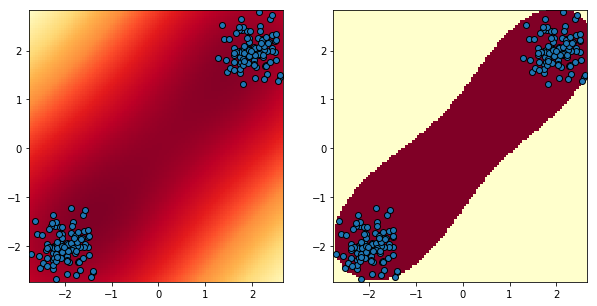

In [13]:
osvm = OSVM(X)
nu = 0.001
sigma2 = 20
osvm.fit(nu, sigma2)
osvm.plot_pred_plan()

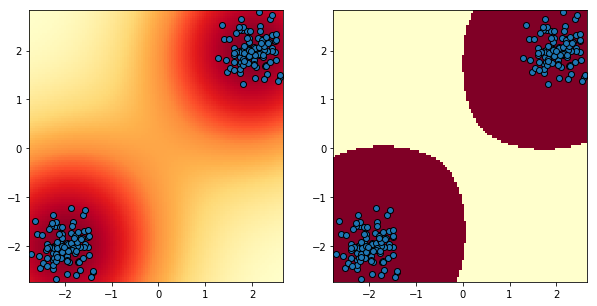

In [14]:
osvm2 = OSVM2(X)
nu = 0.001
sigma2 = 5
osvm2.fit(nu, sigma2)
osvm2.plot_pred_plan()

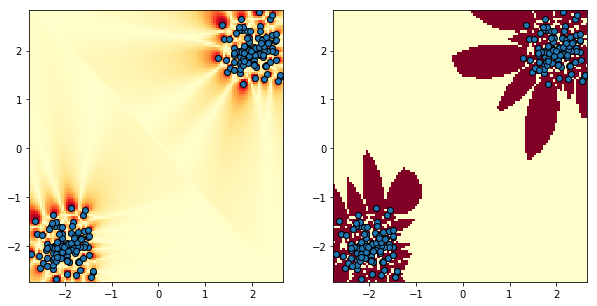

In [19]:
oknn = OkNN(X)
oknn.fit(thresh = 0.9, k = 1)
oknn.plot_pred_plan()

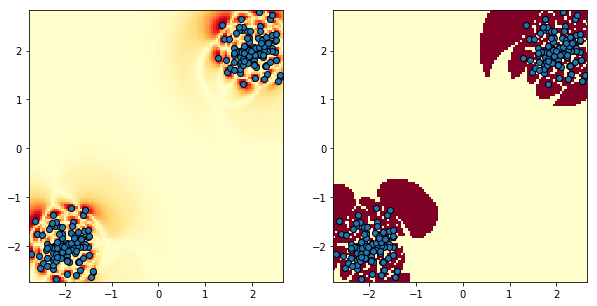

In [20]:
oknn = OkNN(X)
oknn.fit(thresh = 0.9, k = 1, kernel = True)
oknn.plot_pred_plan()

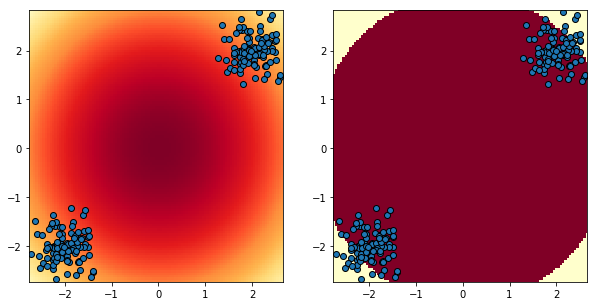

In [21]:
okmeans = OkMeans(X)
okmeans.fit(thresh = 10, k = 1)
okmeans.plot_pred_plan()

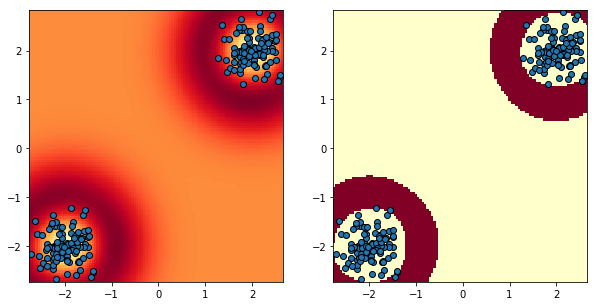

In [22]:
okmeans = OkMeans(X)
okmeans.fit(thresh = 20, k = 1, kernel = True)
okmeans.plot_pred_plan()

### Variant of SMO (Sequential Minimal Optimization) : NE MARCHE PAS

In [ ]:
def get_C(alpha, K, i, j):
    ix = [x for x in range(len(alpha)) if x not in [i,j]]
    amp_alpha = alpha[ix]
    amp_K = K[ix,:][:,ix]
    
    return np.dot(amp_alpha, np.dot(amp_K, amp_alpha))

def get_Os(alpha, K, i, j):
    Os = K[:,i] * alpha[i] + K[:,j] * alpha[j] + get_Cs(alpha, K, i, j)
    return Os

def get_Cs(alpha, K, i, j):
    ix = [x for x in range(len(alpha)) if x not in [i,j]]
    amp_alpha = alpha[ix]
    amp_K = K[:,ix]
    Cs = np.dot(amp_K, amp_alpha)
    return Cs

def is_support(alpha, u_bound, tol = 1e-7):
    return (alpha >= tol) & (alpha <= -tol + u_bound)

def update_rho(alpha, K, nu, u_bound):
    n = len(alpha) # n = self.n
    #nu = self.nu
    ix_support = np.where(is_support(alpha, u_bound))[0][0]
    rho = np.inner(np.reshape(alpha, (1,n)), K[:,ix_support])
    return rho

def update_alpha(alpha, K, i, j, u_bound):
    ix = [x for x in range(len(alpha)) if x not in [i,j]]
    amp_alpha = alpha[ix]
    delta = 1 - np.sum(amp_alpha)
    #Ci, Cj = get_Cs(alpha, K, i, j)
    #alpha[j] = (delta * (K[i,i] - K[i,j]) + Ci - Cj) / (K[i,i] + K[j,j] - 2*K[i,j])
    Os = get_Os(alpha, K, i, j)
    alpha[j] = alpha[j] + (Os[i] - Os[j]) / (K[i,i] + K[j,j] - 2*K[i,j])
    alpha[i] = delta - alpha[j]
    print alpha[i], alpha[j]
    alpha = project_alpha(alpha, i, j, delta, u_bound)
    print alpha[i], alpha[j]
    return alpha

def project_alpha(alpha, i, j, delta, u_bound):
    if (is_support(alpha[i], u_bound, tol = 0) & is_support(alpha[j], u_bound, tol = 0)):
        return alpha
    else:
        alpha[j] = max(0, min(min(delta,u_bound), alpha[j]))
        alpha[i] = max(0, min(u_bound, delta - alpha[j]))
        return alpha

In [ ]:
if False:
    ### Initialization
    nu = 0.12
    n = X.shape[0]

    # Initialization of alpha
    u_bound = 1./(nu*n)
    alpha = np.zeros(n)
    ix_non_zero = np.random.choice(range(n), int(np.floor(nu*n)), False)
    alpha[ix_non_zero] = u_bound
    if type(nu*n) != int:
        ix = np.where(alpha == 0)[0]
        ix = np.random.choice(ix, 1)
        alpha[ix] = 1-np.sum(alpha)
        ix_non_zero = np.append(ix_non_zero, ix)

    # Initialization of rho
    K = osvm.RBF_Kernel(X, 1)
    i = np.arange(n)[ix_non_zero[0]]
    j = np.arange(n)[ix_non_zero[1]]
    Os = get_Os(alpha, K, i, j)
    rho = np.max(Os[ix_non_zero])
    alpha = update_alpha(alpha, K, i, j, u_bound)
    rho = update_rho(alpha, K, nu, u_bound)


    ### Optimization
    cond1 = (Os - rho) * alpha > 1e-7
    cond2 = (rho - Os) * (u_bound - alpha) > 1e-7
    cond = cond1 | cond2
    count = 0
    while(sum(cond) > 1):
        count = count +1
        i = np.where(cond)[0][0]
        ix_support = np.where(is_support(alpha, u_bound))[0]
        j = ix_support[np.argmax(np.abs(Os[i] - Os[ix_support]))]
        alpha = update_alpha(alpha, K, i, j, u_bound)
        rho = update_rho(alpha, K, nu, u_bound)

        cond1 = (Os - rho) * alpha > 1e-7
        cond2 = (rho - Os) * (u_bound - alpha) > 1e-7
        cond = cond1 | cond2

        if count > 10000:
            break